Hematological and platelet-derived inflammatory markers in relation to androgen excess in women with PCOS

Statistical analysis notebook:

Notebook: Piorkowska_Jonczyk_03_statistical_analysis.ipynb

Target journal: The Journal of Clinical Endocrinology & Metabolism

Version: v1.1

Aim: Reproducible workflow for AC (main) + CC (sensitivity) analyses of androgen markers vs CBC-derived platelet/inflammatory indices.

Main dataset: AC (available-case)
Sensitivity: CC (complete-case; rebuild from AC if missing/identical)
Primary predictors: FAI, total testosterone, DHEAS
Primary outcomes: MPV, PDW, P-LCR, RDW, NLR, PLR
Secondary outcomes: PLT, PCT, RDW-SD, WBC, monocytes, MPR (optional)
Stats: Spearman + BH-FDR within families; OLS + HC3 robust SE (crude / IR / IR+age)

### **Imports**

In [ ]:
import re, json, hashlib, platform, unicodedata
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

print("Python:", platform.python_version())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("statsmodels:", sm.__version__)


Python: 3.12.12
pandas: 2.2.2
numpy: 2.0.2
statsmodels: 0.14.6


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# ===== INPUT =====
XLSX_PATH = "/content/patients_results.xlsx"
SHEET_NAME = 0

# ===== OUTPUT =====
OUTDIR = Path("/content/outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# ===== SETTINGS =====
MIN_N_CORR = 30
MIN_N_REG_PRIMARY = 30
MIN_N_REG_SECONDARY = 30

FDR_METHOD = "fdr_bh"
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

print("OUTDIR:", OUTDIR)


OUTDIR: /content/outputs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Helper: sha256 + safe CSV save**

In [ ]:
def sha256_file(path: str) -> str:
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), b""):
            h.update(chunk)
    return h.hexdigest()

def save_csv(df: pd.DataFrame, path: Path, allow_empty=True):
    if df is None:
        df = pd.DataFrame()
    if (df.shape[0] == 0) and (df.shape[1] == 0) and (not allow_empty):
        print(f"[WARN] Not saving fully-empty object: {path.name}")
        return
    df.to_csv(path, index=False)
    print(f"Saved: {path.name} | shape: {df.shape}")

def clean_colname(s: str) -> str:
    s = str(s).replace("\xa0", " ")
    s = s.replace("\r", " ").replace("\n", " ").replace("\t", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def normalize_text(s: str) -> str:
    s = clean_colname(s).lower()
    s = "".join(ch for ch in unicodedata.normalize("NFKD", s) if not unicodedata.combining(ch))
    return s


### **Load datasets**

In [ ]:
xlsx_sha = sha256_file(XLSX_PATH)
print("XLSX sha256:", xlsx_sha)

raw = pd.read_excel(XLSX_PATH, sheet_name=SHEET_NAME)
raw = raw.copy()
raw.columns = [clean_colname(c) for c in raw.columns]

print("Loaded raw:", raw.shape)
print("First 20 columns:", list(raw.columns)[:20])


XLSX sha256: 9d1026ea8f9ca721a5db1f90f391a0df1b29e163b1ac152934258bc3225bafaf
Loaded raw: (1315, 202)
First 20 columns: ['Nr KG', 'Rok KG', 'Przyjęcie na oddział zlecający', 'Wypis z oddziału zlecającego', 'Wiek', '17 - OH progesteron (L79) (17-OHPG)', '17 OH progesteron (L79)', 'ALAT (ALT)', 'AMH (hormon anty-Mullerowski) (AMH_CP)', 'AMH-anty Mullerian Hormon (AMH)', 'APTT Czas kaolinowo-kefalinowy (APTTCZ)', 'ASO - ilościowo (ASOIL)', 'ASPAT (AST)', 'Androstendion (ANDRO)', 'Androstendion (I31)', 'Androstendion (I31) (ANDRO)', 'Anty - HCV (L_ANTHCV)', 'Anty-TG (O18)', 'Anty-TG (p/c przeciw tyreoglobulinie) (ATG)', 'Anty-TPO (ATA_TPO)']


### **Parser liczbowy (przecinki + <LOD)**

In [ ]:
def parse_numeric_series(s: pd.Series, lod_mode: str = "half") -> pd.Series:
    """
    lod_mode:
      - "half": "<0.6" -> 0.3 (LOD/2)
      - "lod":  "<0.6" -> 0.6
    """
    ss = s.astype("string").str.strip()
    is_lt = ss.str.startswith("<", na=False)

    ss = ss.str.replace(",", ".", regex=False)
    ss_clean = ss.str.replace(r"[^\d\.\-\+eE]", "", regex=True)

    num = pd.to_numeric(ss_clean, errors="coerce")

    if lod_mode == "half":
        num = num.where(~is_lt, num / 2)
    elif lod_mode == "lod":
        num = num.where(~is_lt, num)

    return num


### **Regex mapping**

In [ ]:
PATTERNS = {
    # meta
    "age":        [r"\bwiek\b"],

    # inflammation
    "crp":        [r"bialko.*reaktywne.*\(\s*crp\s*\)", r"\(\s*crp\s*\)"],

    # glucose / insulin
    "glucose_0":  [r"l_glu_0", r"krzywa cukrowa.*l_glu_0", r"^glukoza.*\(l_glu\)"],
    "glucose_120":[r"\bglu120\b"],

    "insulin_0":  [r"insul_0", r"insulina.*0m", r"^insulina.*\(insul\)"],
    "insulin_60": [r"insulina.*60m", r"insul_1"],
    "insulin_120":[r"insulina.*120m", r"insul_2"],

    # CBC
    "wbc":        [r"morfologia\s*cbc.*\(\s*wbc\s*\)"],
    "plt":        [r"morfologia\s*cbc.*\(\s*plt\s*\)"],
    "mpv":        [r"morfologia\s*cbc.*\(\s*mpv\s*\)"],
    "pdw":        [r"morfologia\s*cbc.*\(\s*pdw\s*\)"],
    "p_lcr":      [r"morfologia\s*cbc.*\(\s*plcr\s*\)"],
    "pct":        [r"morfologia\s*cbc.*\(\s*pct\s*\)"],
    "rdw":        [r"morfologia\s*cbc.*\(\s*rdw\s*\)"],
    "rdw_sd":     [r"morfologia\s*cbc.*\(\s*rdwsd\s*\)"],

    # 5-Diff (LIM = lymph)
    "neut_pct":   [r"5\s*diff.*\(\s*neut\s*\)"],
    "neut_abs":   [r"5\s*diff.*\(\s*neut#\s*\)"],
    "lymph_pct":  [r"5\s*diff.*\(\s*lim\s*\)"],
    "lymph_abs":  [r"5\s*diff.*\(\s*lim#\s*\)"],
    "mono_pct":   [r"5\s*diff.*\(\s*mon\s*\)"],
    "mono_abs":   [r"5\s*diff.*\(\s*mon#\s*\)"],
    "eos_pct":    [r"5\s*diff.*\(\s*eos\s*\)"],
    "eos_abs":    [r"5\s*diff.*\(\s*eos#\s*\)"],
    "ig_pct":     [r"5\s*diff.*\(\s*ig_p\s*\)"],
    "ig_abs":     [r"5\s*diff.*\(\s*ig_b\s*\)"],
}

def find_matches(columns: list[str], patterns: list[str]) -> list[str]:
    norm_cols = [(c, normalize_text(c)) for c in columns]
    hits = []
    for pat in patterns:
        rx = re.compile(pat, flags=re.IGNORECASE)
        for orig, norm in norm_cols:
            if rx.search(norm):
                hits.append(orig)
    seen = set()
    out = []
    for h in hits:
        if h not in seen:
            out.append(h); seen.add(h)
    return out

def coalesce_numeric(df: pd.DataFrame, cols: list[str], lod_mode="half") -> pd.Series:
    out = pd.Series(np.nan, index=df.index, dtype="float64")
    for c in cols:
        s = df[c]
        if s.notna().sum() == 0:
            continue
        parsed = parse_numeric_series(s, lod_mode=lod_mode)
        out = out.combine_first(parsed)
    return out

def build_std(df_raw: pd.DataFrame, patterns_dict: dict, lod_mode="half") -> tuple[pd.DataFrame, pd.DataFrame]:
    df_raw = df_raw.copy()
    df_raw.columns = [clean_colname(c) for c in df_raw.columns]
    cols = list(df_raw.columns)

    std = pd.DataFrame(index=df_raw.index)
    log_rows = []

    for tgt, pats in patterns_dict.items():
        matched = find_matches(cols, pats)
        if not matched:
            log_rows.append({"target": tgt, "matched_cols": "", "parsed_nonmissing": 0})
            continue

        series = coalesce_numeric(df_raw, matched, lod_mode=lod_mode)
        std[tgt] = series

        log_rows.append({
            "target": tgt,
            "matched_cols": "; ".join(matched),
            "parsed_nonmissing": int(series.notna().sum())
        })

    return std, pd.DataFrame(log_rows)


### **Build standardized df + log + debug dopasowań**

In [ ]:
df, map_log = build_std(raw, PATTERNS, lod_mode="half")

save_csv(map_log, OUTDIR / "S_numeric_parsing_log_STD.csv", allow_empty=True)

print("STD shape:", df.shape)
print("STD columns:", sorted(df.columns))

print("\n=== MATCHES (non-empty) ===")
print(map_log[map_log["matched_cols"] != ""].sort_values("parsed_nonmissing", ascending=False).to_string(index=False))

print("\n=== TARGETS WITH NO MATCH ===")
print(map_log[map_log["matched_cols"] == ""][["target"]].T.to_string(index=False))


/tmp/ipython-input-2832583173.py:61: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  out = out.combine_first(parsed)
/tmp/ipython-input-2832583173.py:61: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  out = out.combine_first(parsed)
/tmp/ipython-input-2832583173.py:61: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  out = out.combine_first(par

Saved: S_numeric_parsing_log_STD.csv | shape: (25, 3)
STD shape: (1315, 25)
STD columns: ['age', 'crp', 'eos_abs', 'eos_pct', 'glucose_0', 'glucose_120', 'ig_abs', 'ig_pct', 'insulin_0', 'insulin_120', 'insulin_60', 'lymph_abs', 'lymph_pct', 'mono_abs', 'mono_pct', 'mpv', 'neut_abs', 'neut_pct', 'p_lcr', 'pct', 'pdw', 'plt', 'rdw', 'rdw_sd', 'wbc']

=== MATCHES (non-empty) ===
     target                                                                                                                                                                                                                                                                            matched_cols  parsed_nonmissing
        age                                                                                                                                                                                                                                                                                    Wiek               131

### **HOMA-IR + logi + NLR/PLR + debug non-missing**

In [ ]:
def infer_glucose_units(g: pd.Series) -> str:
    g = g.dropna()
    if len(g) == 0:
        return "unknown"
    med = float(np.median(g))
    return "mg/dL" if med > 20 else "mmol/L"

meta = {"homa_computed": False, "glucose_units": None}

if ("glucose_0" in df.columns) and ("insulin_0" in df.columns):
    units = infer_glucose_units(df["glucose_0"])
    meta["glucose_units"] = units
    glucose_mmol = df["glucose_0"] / 18.0 if units == "mg/dL" else df["glucose_0"]

    df["homa_ir"] = (glucose_mmol * df["insulin_0"]) / 22.5
    df["log_homa_ir"] = np.log1p(df["homa_ir"])
    meta["homa_computed"] = True

if "crp" in df.columns:
    df["log_crp"] = np.log1p(df["crp"])

if "neut_abs" in df.columns and "lymph_abs" in df.columns:
    df["nlr"] = df["neut_abs"] / df["lymph_abs"]
elif "neut_pct" in df.columns and "lymph_pct" in df.columns:
    df["nlr"] = df["neut_pct"] / df["lymph_pct"]

if "plt" in df.columns and "lymph_abs" in df.columns:
    df["plr"] = df["plt"] / df["lymph_abs"]

print("Meta:", meta)

print("\n=== NON-MISSING CHECK ===")
for c in ["crp","glucose_0","insulin_0","homa_ir","log_homa_ir","wbc","plt","mpv","neut_pct","lymph_pct","mono_pct","nlr"]:
    if c in df.columns:
        print(f"{c:12s} non-missing = {df[c].notna().sum()}")
    else:
        print(f"{c:12s} MISSING")


Meta: {'homa_computed': True, 'glucose_units': 'mg/dL'}

=== NON-MISSING CHECK ===
crp          non-missing = 19
glucose_0    non-missing = 1174
insulin_0    non-missing = 1069
homa_ir      non-missing = 1062
log_homa_ir  non-missing = 1062
wbc          non-missing = 46
plt          non-missing = 46
mpv          non-missing = 46
neut_pct     non-missing = 918
lymph_pct    non-missing = 918
mono_pct     non-missing = 918
nlr          non-missing = 918


### **QC coverage**

In [ ]:
def qc_coverage(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    n = len(df)
    for col in sorted(df.columns):
        miss = int(df[col].isna().sum())
        rows.append({
            "variable": col,
            "n_total": n,
            "n_nonmissing": int(n - miss),
            "n_missing": miss,
            "pct_missing": float(miss / max(n,1))
        })
    return pd.DataFrame(rows)

qc = qc_coverage(df)
save_csv(qc, OUTDIR / "QC_coverage_STD.csv", allow_empty=True)


Saved: QC_coverage_STD.csv | shape: (30, 5)


### **Zestawy zmiennych do analiz**

In [ ]:
COV_MAIN = [c for c in ["age"] if c in df.columns and df[c].notna().sum() > 0]
PRED_IR  = [c for c in ["log_homa_ir","homa_ir"] if c in df.columns and df[c].notna().sum() > 0]

PRIMARY_PLATELET = [c for c in ["mpv","pdw","p_lcr","rdw","rdw_sd","plt","pct"] if c in df.columns and df[c].notna().sum() > 0]
PRIMARY_INFLAM   = [c for c in ["wbc","crp","log_crp","nlr"] if c in df.columns and df[c].notna().sum() > 0]
SECONDARY_CBC    = [c for c in ["wbc","plt","mpv","rdw_sd","neut_pct","lymph_pct","mono_pct","eos_pct","ig_pct","nlr","plr"] if c in df.columns and df[c].notna().sum() > 0]

print("COV_MAIN:", COV_MAIN)
print("PRED_IR:", PRED_IR)
print("PRIMARY_PLATELET:", PRIMARY_PLATELET)
print("PRIMARY_INFLAM:", PRIMARY_INFLAM)
print("SECONDARY_CBC:", SECONDARY_CBC)

if len(PRED_IR) == 0:
    raise RuntimeError("PRED_IR jest puste — HOMA-IR nie powstało. Sprawdź NON-MISSING CHECK.")


COV_MAIN: ['age']
PRED_IR: ['log_homa_ir', 'homa_ir']
PRIMARY_PLATELET: ['mpv', 'pdw', 'p_lcr', 'rdw', 'rdw_sd', 'plt', 'pct']
PRIMARY_INFLAM: ['wbc', 'crp', 'log_crp', 'nlr']
SECONDARY_CBC: ['wbc', 'plt', 'mpv', 'rdw_sd', 'neut_pct', 'lymph_pct', 'mono_pct', 'eos_pct', 'ig_pct', 'nlr']


### **Descriptives**

In [ ]:
def descriptives(df: pd.DataFrame, vars_: list[str]) -> pd.DataFrame:
    out = []
    for v in vars_:
        x = pd.to_numeric(df[v], errors="coerce").dropna()
        if len(x) == 0:
            out.append({"variable":v,"n":0,"mean":np.nan,"sd":np.nan,"median":np.nan,"iqr":np.nan,"min":np.nan,"max":np.nan})
            continue
        q1, q3 = np.percentile(x, [25, 75])
        out.append({
            "variable": v,
            "n": int(len(x)),
            "mean": float(np.mean(x)),
            "sd": float(np.std(x, ddof=1)) if len(x) > 1 else np.nan,
            "median": float(np.median(x)),
            "iqr": float(q3 - q1),
            "min": float(np.min(x)),
            "max": float(np.max(x)),
        })
    return pd.DataFrame(out)

DESC_VARS = sorted(set(COV_MAIN + PRED_IR + PRIMARY_PLATELET + PRIMARY_INFLAM + SECONDARY_CBC + ["glucose_0","insulin_0","crp"]))
DESC_VARS = [v for v in DESC_VARS if v in df.columns]

desc = descriptives(df, DESC_VARS)
save_csv(desc, OUTDIR / "DESCRIPTIVES_STD.csv", allow_empty=True)


Saved: DESCRIPTIVES_STD.csv | shape: (21, 8)


### **Korelacje (Pearson + FDR)**

In [ ]:
def corr_table(df: pd.DataFrame, y_vars: list[str], x_vars: list[str]) -> pd.DataFrame:
    rows = []
    for y in y_vars:
        for x in x_vars:
            if y == x:
                continue
            tmp = df[[y, x]].dropna()
            n = tmp.shape[0]
            if n < MIN_N_CORR:
                continue
            r, p = stats.pearsonr(tmp[y], tmp[x])
            rows.append({"y":y,"x":x,"n":int(n),"r":float(r),"p":float(p)})

    out = pd.DataFrame(rows)
    if out.empty:
        return pd.DataFrame(columns=["y","x","n","r","p","q"])

    out["q"] = multipletests(out["p"].values, method=FDR_METHOD)[1]
    return out.sort_values(["q","p"]).reset_index(drop=True)

save_csv(corr_table(df, PRIMARY_PLATELET, PRED_IR), OUTDIR / "corr_PRIMARY_platelet_STD.csv", allow_empty=True)
save_csv(corr_table(df, PRIMARY_INFLAM, PRED_IR), OUTDIR / "corr_PRIMARY_inflam_STD.csv", allow_empty=True)
save_csv(corr_table(df, SECONDARY_CBC, PRED_IR), OUTDIR / "corr_SECONDARY_CBC_STD.csv", allow_empty=True)


Saved: corr_PRIMARY_platelet_STD.csv | shape: (0, 6)
Saved: corr_PRIMARY_inflam_STD.csv | shape: (2, 6)
Saved: corr_SECONDARY_CBC_STD.csv | shape: (12, 6)


### **Regresje OLS + HC3**

In [ ]:
def regress_block(df: pd.DataFrame, outcomes: list[str], predictors: list[str], covars: list[str], min_n: int) -> pd.DataFrame:
    rows = []
    for y in outcomes:
        for x in predictors:
            cols = [y, x] + covars
            tmp = df[cols].dropna()
            n = tmp.shape[0]
            if n < min_n:
                continue

            Y = tmp[y].astype(float).values
            X = sm.add_constant(tmp[[x] + covars].astype(float), has_constant="add")

            model = sm.OLS(Y, X).fit(cov_type="HC3")

            rows.append({
                "outcome": y,
                "predictor": x,
                "covars": "+".join(covars) if covars else "",
                "n": int(n),
                "beta": float(model.params.get(x, np.nan)),
                "se_hc3": float(model.bse.get(x, np.nan)),
                "t": float(model.tvalues.get(x, np.nan)),
                "p": float(model.pvalues.get(x, np.nan)),
                "r2": float(model.rsquared),
            })

    out = pd.DataFrame(rows)
    if out.empty:
        return pd.DataFrame(columns=["outcome","predictor","covars","n","beta","se_hc3","t","p","q","r2"])

    out["q"] = multipletests(out["p"].values, method=FDR_METHOD)[1]
    return out.sort_values(["q","p"]).reset_index(drop=True)

save_csv(regress_block(df, PRIMARY_PLATELET + PRIMARY_INFLAM, PRED_IR, COV_MAIN, MIN_N_REG_PRIMARY),
         OUTDIR / "REG_primary_models_HC3_STD.csv", allow_empty=True)

save_csv(regress_block(df, SECONDARY_CBC, PRED_IR, COV_MAIN, MIN_N_REG_SECONDARY),
         OUTDIR / "REG_secondary_models_HC3_STD.csv", allow_empty=True)


Saved: REG_primary_models_HC3_STD.csv | shape: (2, 10)
Saved: REG_secondary_models_HC3_STD.csv | shape: (12, 10)


In [ ]:
from typing import Iterable

def missingness_table(df: pd.DataFrame, vars_: list[str]) -> pd.DataFrame:
    rows = []
    n_total = df.shape[0]
    for v in vars_:
        if v not in df.columns:
            continue
        miss_n = int(df[v].isna().sum())
        nonmiss_n = int(df[v].notna().sum())
        rows.append({
            "var": v,
            "n_total": n_total,
            "n_nonmissing": nonmiss_n,
            "missing_n": miss_n,
            "missing_pct": (miss_n / n_total * 100.0) if n_total else np.nan,
        })
    return pd.DataFrame(rows).sort_values(["missing_pct","var"], ascending=[False, True])

def descriptives_plus(df: pd.DataFrame, vars_: list[str], shapiro_max_n: int = 5000) -> pd.DataFrame:
    '''
    Rozszerzenie descriptives(): dodaje missing%, Q1/Q3 oraz (opcjonalnie) Shapiro p-value na próbie.
    Shapiro traktuj jako QC/sygnał diagnostyczny, NIE jako bramkę decyzyjną przy dużych N.
    '''
    rows = []
    for v in vars_:
        if v not in df.columns:
            continue
        x = pd.to_numeric(df[v], errors="coerce")
        n_total = int(x.shape[0])
        n = int(x.notna().sum())
        miss_n = int(x.isna().sum())
        if n == 0:
            continue

        x_non = x.dropna().astype(float)
        q1 = float(np.nanpercentile(x_non, 25))
        q3 = float(np.nanpercentile(x_non, 75))
        med = float(np.nanmedian(x_non))
        iqr = float(q3 - q1)
        mean = float(np.nanmean(x_non))
        sd = float(np.nanstd(x_non, ddof=1)) if n > 1 else np.nan
        mn = float(np.nanmin(x_non))
        mx = float(np.nanmax(x_non))

        shapiro_p = np.nan
        try:
            if n >= 3:
                x_s = x_non.sample(n=min(n, shapiro_max_n), random_state=123)
                shapiro_p = float(stats.shapiro(x_s).pvalue)
        except Exception:
            shapiro_p = np.nan

        rows.append({
            "var": v,
            "n_total": n_total,
            "n_nonmissing": n,
            "missing_n": miss_n,
            "missing_pct": (miss_n / n_total * 100.0) if n_total else np.nan,
            "mean": mean,
            "sd": sd,
            "median": med,
            "iqr": iqr,
            "q1": q1,
            "q3": q3,
            "min": mn,
            "max": mx,
            "shapiro_p_qc": shapiro_p,
        })
    return pd.DataFrame(rows)

def corr_table_any(df: pd.DataFrame, y_vars: list[str], x_vars: list[str], method: str = "spearman", min_n: int = 25) -> pd.DataFrame:
    '''
    Korelacje Pearson/Spearman + FDR(BH). Spearman jako domyślny (bardziej odporny na skośność/outliery).
    '''
    method = method.lower().strip()
    if method not in {"pearson","spearman"}:
        raise ValueError("method must be 'pearson' or 'spearman'")

    rows = []
    for y in y_vars:
        for x in x_vars:
            if y not in df.columns or x not in df.columns:
                continue
            tmp = df[[y, x]].dropna()
            n = tmp.shape[0]
            if n < min_n:
                continue
            yy = pd.to_numeric(tmp[y], errors="coerce")
            xx = pd.to_numeric(tmp[x], errors="coerce")
            tmp2 = pd.concat([yy, xx], axis=1).dropna()
            n2 = tmp2.shape[0]
            if n2 < min_n:
                continue

            if method == "pearson":
                r, p = stats.pearsonr(tmp2.iloc[:,0].astype(float), tmp2.iloc[:,1].astype(float))
            else:
                r, p = stats.spearmanr(tmp2.iloc[:,0].astype(float), tmp2.iloc[:,1].astype(float), nan_policy="omit")

            rows.append({"y": y, "x": x, "n": int(n2), "r": float(r), "p": float(p), "method": method})

    out = pd.DataFrame(rows)
    if out.empty:
        return out
    out["q"] = multipletests(out["p"].values, method="fdr_bh")[1]
    return out.sort_values(["q","p","y","x"], ascending=[True, True, True, True]).reset_index(drop=True)

def cooks_distance_summary_for_pairs(df: pd.DataFrame, outcomes: list[str], predictors: list[str], covars: list[str], min_n: int = 25) -> pd.DataFrame:
    '''
    QC: ile obserwacji ma Cook's D > 4/n w każdym modelu.
    Nie usuwa obserwacji automatycznie — to diagnostyka + ewentualna analiza wrażliwości.
    '''
    rows = []
    for y in outcomes:
        for x in predictors:
            cols = [y, x] + covars
            cols = [c for c in cols if c in df.columns]
            tmp = df[cols].dropna()
            n = tmp.shape[0]
            if n < min_n:
                continue

            yv = pd.to_numeric(tmp[y], errors="coerce").astype(float)
            X = tmp[[x] + [c for c in covars if c in tmp.columns]].apply(pd.to_numeric, errors="coerce").astype(float)
            X = sm.add_constant(X, has_constant="add")
            tmp3 = pd.concat([yv, X], axis=1).dropna()
            if tmp3.shape[0] < min_n:
                continue

            yv2 = tmp3.iloc[:,0].astype(float)
            X2 = tmp3.iloc[:,1:].astype(float)

            try:
                model = sm.OLS(yv2, X2).fit()
                infl = model.get_influence()
                cooks_d = infl.cooks_distance[0]
                thr = 4.0 / tmp3.shape[0]
                rows.append({
                    "outcome": y,
                    "predictor": x,
                    "covars": "+".join([c for c in covars if c in tmp.columns]) if covars else "",
                    "n": int(tmp3.shape[0]),
                    "cooks_threshold_4_over_n": float(thr),
                    "n_cooks_gt_thr": int(np.sum(cooks_d > thr)),
                    "max_cooks_d": float(np.max(cooks_d)) if len(cooks_d) else np.nan,
                })
            except Exception as e:
                rows.append({
                    "outcome": y,
                    "predictor": x,
                    "covars": "+".join([c for c in covars if c in tmp.columns]) if covars else "",
                    "n": int(tmp3.shape[0]),
                    "cooks_threshold_4_over_n": np.nan,
                    "n_cooks_gt_thr": np.nan,
                    "max_cooks_d": np.nan,
                    "error": str(e)[:200],
                })

    return pd.DataFrame(rows).sort_values(["n_cooks_gt_thr","max_cooks_d"], ascending=[False, False])

KEY_VARS = sorted(set(PRIMARY_PLATELET + PRIMARY_INFLAM + SECONDARY_CBC + COV_MAIN + PRED_IR))
miss_key = missingness_table(df, KEY_VARS)
save_csv(miss_key, OUTDIR / "QC_missingness_keyvars_STD.csv")

desc_plus = descriptives_plus(df, KEY_VARS)
save_csv(desc_plus, OUTDIR / "DESCRIPTIVES_plus_STD.csv")

# Spearman correlations as sensitivity analysis (for IR and CBC)
if len(PRED_IR) > 0:
    corr_spearman_inflam = corr_table_any(df, y_vars=PRIMARY_INFLAM, x_vars=PRED_IR, method="spearman", min_n=MIN_N_CORR)
    save_csv(corr_spearman_inflam, OUTDIR / "corr_PRIMARY_inflam_SPEARMAN_STD.csv")

    corr_spearman_platelet = corr_table_any(df, y_vars=PRIMARY_PLATELET, x_vars=PRED_IR, method="spearman", min_n=MIN_N_CORR)
    save_csv(corr_spearman_platelet, OUTDIR / "corr_PRIMARY_platelet_SPEARMAN_STD.csv")

    corr_spearman_secondary = corr_table_any(df, y_vars=SECONDARY_CBC, x_vars=PRED_IR, method="spearman", min_n=MIN_N_CORR)
    save_csv(corr_spearman_secondary, OUTDIR / "corr_SECONDARY_CBC_SPEARMAN_STD.csv")

ENDO_CANDIDATES = [
    "testosterone", "total_testosterone", "free_testosterone",
    "shbg", "fai", "dheas", "androstendione", "androstenedione",
    "lh", "fsh", "lh_fsh_ratio", "amh", "progesterone", "estradiol", "e2",
    "prolactin", "tsh", "ft4"
]
ENDO_VARS = [c for c in ENDO_CANDIDATES if c in df.columns and df[c].notna().sum() > 0]

LEUKO_CAND = [
    "neut_pct","neutrophils_pct","neutrophil_pct","neut_percent",
    "lymph_pct","lymphocytes_pct","lymphocyte_pct","lymph_percent",
    "nlr"
]
PRIMARY_LEUKO = [c for c in LEUKO_CAND if c in df.columns and df[c].notna().sum() > 0]

def _order(vars_):
    order = {v:i for i,v in enumerate(LEUKO_CAND)}
    return sorted(vars_, key=lambda v: order.get(v, 999))

PRIMARY_LEUKO = _order(PRIMARY_LEUKO)

print("ENDO_VARS (present):", ENDO_VARS)
print("PRIMARY_LEUKO (present):", PRIMARY_LEUKO)

if len(ENDO_VARS) > 0 and len(PRIMARY_LEUKO) > 0:
    corr_endo_s = corr_table_any(df, y_vars=PRIMARY_LEUKO, x_vars=ENDO_VARS, method="spearman", min_n=MIN_N_CORR)
    save_csv(corr_endo_s, OUTDIR / "corr_PRIMARY_leuko_ENDO_SPEARMAN_STD.csv")

    corr_endo_p = corr_table_any(df, y_vars=PRIMARY_LEUKO, x_vars=ENDO_VARS, method="pearson", min_n=MIN_N_CORR)
    save_csv(corr_endo_p, OUTDIR / "corr_PRIMARY_leuko_ENDO_PEARSON_STD.csv")

    # Regressions: outcome ~ endocrine + (age + possibly log_homa_ir) from HC3
    COV_ENDO = [c for c in ["age"] if c in df.columns and df[c].notna().sum() > 0]
    if "log_homa_ir" in df.columns and df["log_homa_ir"].notna().sum() > 0:
        COV_ENDO = COV_ENDO + ["log_homa_ir"]

    reg_endo = regress_block(df, outcomes=PRIMARY_LEUKO, predictors=ENDO_VARS, covars=COV_ENDO, min_n=MIN_N_REG)
    save_csv(reg_endo, OUTDIR / "REG_primary_leuko_ENDO_models_HC3_STD.csv")

    cooks_endo = cooks_distance_summary_for_pairs(df, outcomes=PRIMARY_LEUKO, predictors=ENDO_VARS, covars=COV_ENDO, min_n=MIN_N_REG)
    save_csv(cooks_endo, OUTDIR / "QC_cooksD_primary_leuko_ENDO_STD.csv")
else:
    print("Endocrine block skipped: brak ENDO_VARS i/lub PRIMARY_LEUKO w df.")


Saved: QC_missingness_keyvars_STD.csv | shape: (19, 5)
Saved: DESCRIPTIVES_plus_STD.csv | shape: (19, 14)
Saved: corr_PRIMARY_inflam_SPEARMAN_STD.csv | shape: (2, 7)
Saved: corr_PRIMARY_platelet_SPEARMAN_STD.csv | shape: (0, 0)
Saved: corr_SECONDARY_CBC_SPEARMAN_STD.csv | shape: (12, 7)
ENDO_VARS (present): []
PRIMARY_LEUKO (present): ['neut_pct', 'lymph_pct', 'nlr']
Endocrine block skipped: brak ENDO_VARS i/lub PRIMARY_LEUKO w df.


### **SENSITIVITY (AC vs CC) + MAIN MODEL EXPORT**

In [ ]:

def _pick_main_covars(df: pd.DataFrame) -> list[str]:
    """Prefer: log_homa_ir (or homa_ir) + age; fallback to what exists."""
    covs = []
    for c in ["log_homa_ir", "homa_ir"]:
        if c in df.columns and df[c].notna().sum() > 0:
            covs.append(c)
            break
    if "age" in df.columns and df["age"].notna().sum() > 0:
        covs.append("age")
    return covs

MAIN_COVARS = _pick_main_covars(df)
print("MAIN_COVARS (main inferential model):", MAIN_COVARS if MAIN_COVARS else "[] (crude)")

# Define keyvars for CC
KEYVARS_CC = [c for c in (PRIMARY_LEUKO + ENDO_VARS + MAIN_COVARS) if c in df.columns]
KEYVARS_CC = list(dict.fromkeys(KEYVARS_CC))

if len(KEYVARS_CC) == 0:
    print("CC sensitivity pominięte: brak wspólnych zmiennych do definicji complete-case.")
else:
    df_cc = df.dropna(subset=KEYVARS_CC).copy()
    print(f"Complete-case dataset: n={df_cc.shape[0]} / {df.shape[0]} (keyvars={len(KEYVARS_CC)})")

    # Correlations (Spearman) AC vs CC for PRIMARY_LEUKO x ENDO
    if len(PRIMARY_LEUKO) > 0 and len(ENDO_VARS) > 0:
        corr_leuko_endo_cc = corr_table_any(df_cc, y_vars=PRIMARY_LEUKO, x_vars=ENDO_VARS, method="spearman")
        save_csv(corr_leuko_endo_cc, OUTDIR / "corr_PRIMARY_leuko_ENDO_SPEARMAN_CC.csv")

    # Main model regression AC vs CC (HC3) for PRIMARY_LEUKO ~ ENDO (+ main covars)
    # AC main model
    if len(PRIMARY_LEUKO) > 0 and len(ENDO_VARS) > 0:
        reg_leuko_endo_main_ac = regress_block(df, outcomes=PRIMARY_LEUKO, predictors=ENDO_VARS, covars=MAIN_COVARS, min_n=MIN_N_REG_PRIMARY)
        save_csv(reg_leuko_endo_main_ac, OUTDIR / "REG_primary_leuko_ENDO_MAINMODEL_HC3_AC.csv")

        # CC main model
        reg_leuko_endo_main_cc = regress_block(df_cc, outcomes=PRIMARY_LEUKO, predictors=ENDO_VARS, covars=MAIN_COVARS, min_n=MIN_N_REG_PRIMARY)
        save_csv(reg_leuko_endo_main_cc, OUTDIR / "REG_primary_leuko_ENDO_MAINMODEL_HC3_CC.csv")

        # Cook's D QC on CC models (no deletion; purely diagnostic)
        try:
            cooks_cc = cooks_distance_summary_for_pairs(df_cc, outcomes=PRIMARY_LEUKO, predictors=ENDO_VARS, covars=MAIN_COVARS, min_n=MIN_N_REG_PRIMARY)
            save_csv(cooks_cc, OUTDIR / "QC_cooksD_primary_leuko_ENDO_MAINMODEL_CC.csv")
        except Exception as e:
            print("Cook's distance QC (CC) skipped due to:", repr(e))

    # AC vs CC for IR ↔ CBC correlations (Spearman)

    if len(PRED_IR) > 0:
        for label, yset in [
            ("PRIMARY_inflam", PRIMARY_INFLAM),
            ("PRIMARY_platelet", PRIMARY_PLATELET),
            ("SECONDARY_CBC", SECONDARY_CBC),
        ]:
            if len(yset) == 0:
                continue
            corr_ir_cc = corr_table_any(df_cc, y_vars=yset, x_vars=PRED_IR, method="spearman")
            save_csv(corr_ir_cc, OUTDIR / f"corr_{label}_IR_SPEARMAN_CC.csv")


MAIN_COVARS (main inferential model): ['log_homa_ir', 'age']
Complete-case dataset: n=900 / 1315 (keyvars=5)
Saved: corr_PRIMARY_inflam_IR_SPEARMAN_CC.csv | shape: (2, 7)
Saved: corr_PRIMARY_platelet_IR_SPEARMAN_CC.csv | shape: (0, 0)
Saved: corr_SECONDARY_CBC_IR_SPEARMAN_CC.csv | shape: (12, 7)


### **Diagnostic report (bez warningów)**

In [ ]:
EXPECTED = [
    "S_numeric_parsing_log_STD.csv",
    "QC_coverage_STD.csv",
    "DESCRIPTIVES_STD.csv",
    "corr_PRIMARY_platelet_STD.csv",
    "corr_PRIMARY_inflam_STD.csv",
    "corr_SECONDARY_CBC_STD.csv",
    "REG_primary_models_HC3_STD.csv",
    "REG_secondary_models_HC3_STD.csv",
]

missing = [f for f in EXPECTED if not (OUTDIR / f).exists()]

report = {
    "timestamp": datetime.now(timezone.utc).isoformat(),
    "input": {"xlsx": XLSX_PATH, "sha256": xlsx_sha, "raw_shape": list(raw.shape), "std_shape": list(df.shape)},
    "meta": meta,
    "sets": {
        "COV_MAIN": COV_MAIN,
        "PRED_IR": PRED_IR,
        "PRIMARY_PLATELET": PRIMARY_PLATELET,
        "PRIMARY_INFLAM": PRIMARY_INFLAM,
        "SECONDARY_CBC": SECONDARY_CBC
    },
    "config": {
        "MIN_N_CORR": MIN_N_CORR,
        "MIN_N_REG_PRIMARY": MIN_N_REG_PRIMARY,
        "MIN_N_REG_SECONDARY": MIN_N_REG_SECONDARY,
        "FDR_METHOD": FDR_METHOD
    },
    "environment": {
        "python": platform.python_version(),
        "pandas": pd.__version__,
        "numpy": np.__version__,
        "statsmodels": sm.__version__
    },
    "outputs": {"outdir": str(OUTDIR), "missing": missing},
}

with open(OUTDIR / "diagnostic_report.json", "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)

print("OUTDIR:", OUTDIR)
print("Missing outputs:", missing)
print("Saved diagnostic_report.json")


OUTDIR: /content/outputs
Missing outputs: []
Saved diagnostic_report.json


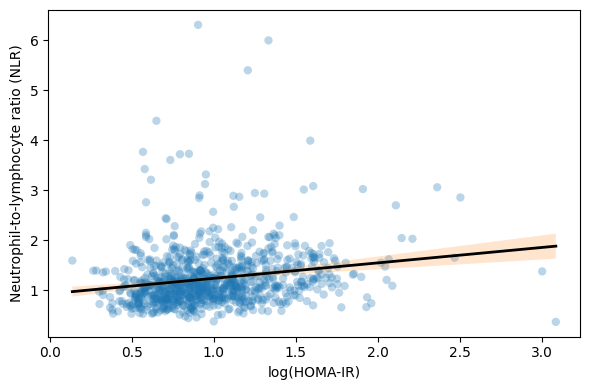

In [ ]:

import statsmodels.api as sm
import matplotlib.pyplot as plt

tmp = df[["nlr", "log_homa_ir", "age"]].dropna()

Y = tmp["nlr"].astype(float)
X = sm.add_constant(tmp[["log_homa_ir", "age"]].astype(float), has_constant="add")

model = sm.OLS(Y, X).fit(cov_type="HC3")

x_grid = np.linspace(tmp["log_homa_ir"].min(),tmp["log_homa_ir"].max(),200)

pred_df = pd.DataFrame({"log_homa_ir": x_grid,"age": tmp["age"].mean() })

X_pred = sm.add_constant(pred_df, has_constant="add")

pred = model.get_prediction(X_pred).summary_frame(alpha=0.05)

pred_df["fit"] = pred["mean"]
pred_df["lci"] = pred["mean_ci_lower"]
pred_df["uci"] = pred["mean_ci_upper"]


plt.figure(figsize=(6, 4))

plt.scatter(tmp["log_homa_ir"],tmp["nlr"],alpha=0.3,edgecolor="none")
plt.plot(pred_df["log_homa_ir"],pred_df["fit"],color="black",linewidth=2)
plt.fill_between(pred_df["log_homa_ir"],pred_df["lci"],pred_df["uci"],alpha=0.2)
plt.xlabel("log(HOMA-IR)")
plt.ylabel("Neutrophil-to-lymphocyte ratio (NLR)")
plt.tight_layout()
plt.show()


PRIMARY_LEUKO: ['neut_pct', 'lymph_pct', 'nlr']
     outcome    n      beta    se_hc3    ci_low   ci_high            label
2        nlr  900  0.535829  0.102674  0.334588  0.737069              NLR
1  lymph_pct  900 -0.573188  0.116247 -0.801032 -0.345345  Lymphocytes (%)
0   neut_pct  900  0.678385  0.114563  0.453841  0.902928  Neutrophils (%)


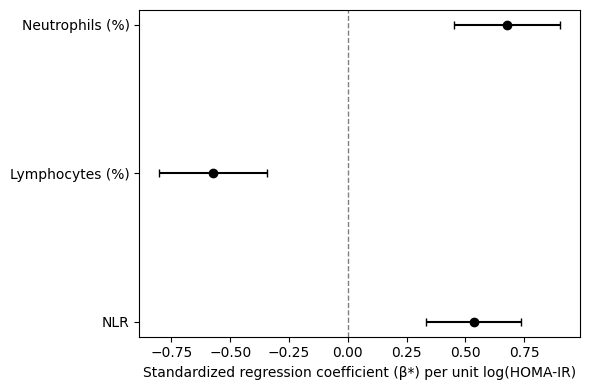

In [ ]:

from sklearn.preprocessing import StandardScaler

rows = []

print("PRIMARY_LEUKO:", PRIMARY_LEUKO)

scaler = StandardScaler()
df_std = df.copy()

for c in PRIMARY_LEUKO:
    if c in df_std.columns:
        df_std[c + "_z"] = scaler.fit_transform(df_std[[c]])

for y in PRIMARY_LEUKO:
    y_z = y + "_z"
    cols = [y_z, "log_homa_ir", "age"]

    if not all(c in df_std.columns for c in cols):
        continue
    tmp = df_std[cols].dropna()
    if tmp.shape[0] < MIN_N_REG_PRIMARY:
        continue

    Y = tmp[y_z].astype(float)
    X = sm.add_constant(tmp[["log_homa_ir", "age"]].astype(float), has_constant="add")

    model = sm.OLS(Y, X).fit(cov_type="HC3")
    rows.append({"outcome": y,"n": int(tmp.shape[0]),
        "beta": float(model.params["log_homa_ir"]),"se_hc3": float(model.bse["log_homa_ir"]),})
z = 1.96
fig2_df = pd.DataFrame(rows)
fig2_df["ci_low"] = fig2_df["beta"] - z * fig2_df["se_hc3"]
fig2_df["ci_high"] = fig2_df["beta"] + z * fig2_df["se_hc3"]

label_map = {
    "neut_pct": "Neutrophils (%)",
    "neutrophils_pct": "Neutrophils (%)",
    "lymph_pct": "Lymphocytes (%)",
    "lymphocytes_pct": "Lymphocytes (%)",
    "nlr": "NLR",}

fig2_df["label"] = fig2_df["outcome"].map(label_map)
order = ["Neutrophils (%)", "Lymphocytes (%)", "NLR"]
fig2_df["label"] = pd.Categorical(fig2_df["label"], categories=order, ordered=True)
fig2_df = fig2_df.sort_values("label", ascending=False)

print(fig2_df)

fig, ax = plt.subplots(figsize=(6, 4))
y_pos = np.arange(len(fig2_df))

ax.errorbar(fig2_df["beta"],y_pos,
            xerr=[fig2_df["beta"] - fig2_df["ci_low"],fig2_df["ci_high"] - fig2_df["beta"]],
           fmt="o",color="black",ecolor="black",capsize=3)

ax.axvline(0, color="grey", linestyle="--", linewidth=1)

ax.set_yticks(y_pos)
ax.set_yticklabels(fig2_df["label"])
ax.set_xlabel("Standardized regression coefficient (β*) per unit log(HOMA-IR)")
plt.tight_layout()
plt.show()
